# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 18 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -3 балла после 06:00 18 апреля, -6 баллов после 06:00 25 апреля, -9 баллов после 06:00 2 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# %load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Петренко".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print ("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
))

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \frac{\partial L}{\partial w_i} = \frac{1}{N}\sum_{k=1}^N\left[ \frac{1}{1 + e^{-y^{(k)} \cdot (w_0 + \sum_{l=1}^n w_l \cdot x_l^{(k)})}} \cdot e^{-y^{(k)}\cdot(w_0 + \sum_{l=1}^n w_l \cdot x_l^{(k)})} \cdot \left(-y^{(k)} \cdot x_i^{(k)}\right) \right ] + \frac{1}{C} \frac{\partial {\left | w_i \right |}}{\partial w_i} \\= \frac {1}{N} \sum_{k=1}^N\left [ \sigma \left (-y^{(k)}\cdot g(x^{(k)})\right )\cdot \left ( -y^{(k)} \cdot x_i^{(k)}\right )\right ] + \frac {1}{C}sign\left(w_i \right ) \\ w_i^{j+1} = w_i^{j} - \alpha_j \cdot \frac{\partial L}{\partial w_i} \bigg|_{w=w^j} $$

## Имплементация (5 баллов)

In [3]:
#%%pycodestyle


from sklearn.base import BaseEstimator, ClassifierMixin


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    def __init__(self, C=1, alpha=0.01, max_epoch=10,
                 verbose=False, save_err=False):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.verbose = verbose
        self.save_err = save_err

    def __sigma(self, z):
        return 1. / (1. + np.exp(-z))

    def __absgrad(self):
        '''
        Возвращаем вектор производных |w_j| по w_j
        Считаем, что d(|w_j|)/d(w_j) = sign(w_j)
        '''
        return np.sign(self.__weights)

    def get_weights(self):
        return self.__weights

    def fit(self, X, y=None, refit=False):
        '''
        Обучение модели
        '''
        # конкатенируем к выборке столбец из единиц для удобства вычислений
        new_X = np.hstack((np.ones((X.shape[0], 1), dtype=np.float64), X))\
            .astype(np.float64)
        # переводим метки классов из {0, 1} в {-1, 1}
        new_y = (-1 + 2 * y).astype(np.float64)
        nsamples, ndims = new_X.shape
        if not refit:
            self.__weights = np.random.rand(ndims)
        self.errors = []
        iter_range = range(nsamples)

        if self.save_err:
            err = np.log(self.__sigma(new_y * (new_X * self.__weights)
                                      .sum(axis=1))).sum()
            err = -err / nsamples
            self.errors.append(err)

        for num_epoch in range(1, self.max_epoch + 1):
            # каждая эпоха - проход по всей случайным
            # образом перемешанной выборке
            np.random.shuffle(iter_range)
            for i in iter_range:
                margin = new_y[i] * (new_X[i] * self.__weights).sum()
                partial_grad = (self.__sigma(-margin) * (-new_y[i] * new_X[i])
                                + 1. / self.C * self.__absgrad()) / nsamples

                self.__weights = self.__weights - (self.alpha) * partial_grad
            if self.verbose:
                if num_epoch % 10 == 0:
                    print "Epoch {} done: coeffs are ".format(num_epoch)
                    , self.__weights
            if self.save_err:
                err = np.log(
                    self.__sigma(new_y * (new_X * self.__weights).sum(axis=1))
                ).sum()
                err = -err / nsamples
                self.errors.append(err)

        return self

    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''

        return self.fit(X, y, refit=True)

    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        y_hat = np.argmax(self.predict_proba(X), axis=1)
        return y_hat

    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        new_X = np.hstack((np.ones((X.shape[0], 1), dtype=np.float64), X))
        prob1 = self.__sigma((new_X * self.__weights).sum(axis=1))
        y_hat_proba = np.c_[1 - prob1, prob1]
        return y_hat_proba

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

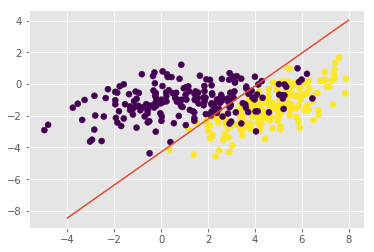

In [4]:
#%%pycodestyle

np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:, 0], X[:, 1], c=y)

mySGDclassifier = MySGDClassifier(C=100, alpha=1, max_epoch=100, save_err=True)
mySGDclassifier.fit(X, y)

y_hat = mySGDclassifier.predict(X)

w = mySGDclassifier.get_weights()
u = np.array([-4, 8])
v = - (u * w[1] + w[0])/w[2]

plt.plot(u, v)

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [5]:
from sklearn.datasets import make_classification

In [6]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

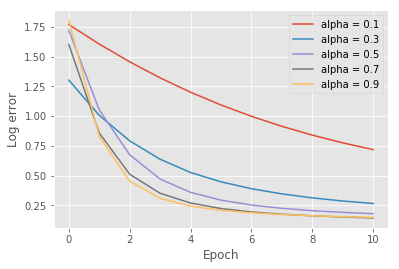

In [7]:
#%%pycodestyle
# Your Code Here
me = 10
alphas = np.arange(0.1, 1.0, 0.2)
for a in alphas:
    clf = MySGDClassifier(C=100, alpha=a, max_epoch=me, save_err=True)
    clf.fit(X, y)
    er = clf.errors
    plt.plot(range(len(er)), er, label='alpha = {}'.format(a))
plt.xlabel('Epoch')
plt.ylabel('Log error')
plt.legend()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

In [8]:
#%%pycodestyle
# Your Code Here
w = []
for C in np.logspace(3, -3, 10):
    clf = MySGDClassifier(C=C, alpha=1, max_epoch=10)
    clf.fit(X, y)
    w.append(clf.get_weights())

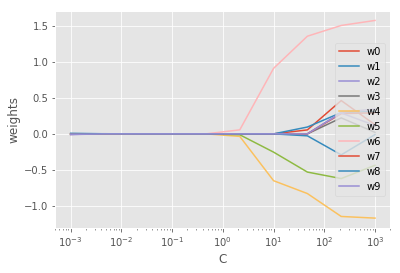

In [9]:
#%%pycodestyle
s = np.array(w)
for i in range(s.shape[0]):
    plt.plot(np.logspace(3, -3, 10), s[:, i], label='w{}'.format(i))
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('weights')
plt.legend()

# Повезло, веса неплохо зануляются даже с sign(w) в качестве градиента модуля

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [10]:
#%%pycodestyle
# Загрузка данных целиком
df_list = []
for chunk in range(1, 5):
    filepath = './trainingData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_data = pd.concat(df_list)

# Загрузка одной части данных
# filepath = './trainingData_tabular_chunk1.csv'
# df_data = pd.read_csv(filepath, sep=',')

In [11]:
df_data.shape

(2000000, 45)

In [12]:
#%%pycodestyle
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [13]:
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [14]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.5047995

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [19]:
#%%pycodestyle
# Youd Code Here
print 'unique player cards {}'.format(
    df_data.loc[:, 'player_hero_card_id'].nunique()
)
print 'unique opponent cards {}'.format(
    df_data.loc[:, 'opponent_hero_card_id'].nunique()
)
df_new = pd.get_dummies(
    df_data, columns=['player_hero_card_id', 'opponent_hero_card_id']
)
df_new.head().T

unique player cards 9
unique opponent cards 9


gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1
opponent_deck_count,11,19,22,17,12


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [21]:
#%%pycodestyle
# Youd Code Here
X, y = df_new.iloc[:, 1:].values, df_new.iloc[:, 0].values
pip = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('lr', MySGDClassifier(C=100, alpha=1, max_epoch=10))])

In [22]:
%time pip.fit(X, y)

/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


CPU times: user 8min 30s, sys: 9.59 s, total: 8min 39s
Wall time: 8min 55s


Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', MySGDClassifier(C=100, alpha=1, max_epoch=10, save_err=False, verbose=False))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [23]:
#%%pycodestyle
# Youd Code Here
df_list = []
for chunk in range(5, 8):
    filepath = './testData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_test = pd.concat(df_list)


In [24]:
#%%pycodestyle
df_test.columns = df_test.columns.str.replace('.', '_')
df_test = df_test.set_index('gamestate_id')

In [25]:
#%%pycodestyle
df_test = pd.get_dummies(df_test, columns=[
    'player_hero_card_id',
    'opponent_hero_card_id'
])
df_test = df_test.drop('decision', axis=1)

In [26]:
X_test = df_test.values

In [27]:
path = './deprecated_testLabels.txt'
y_test = pd.read_csv(path, names=['ans']).values

In [28]:
%time y_hat = pip.predict(X_test)

CPU times: user 1.62 s, sys: 1.85 s, total: 3.47 s
Wall time: 4.51 s


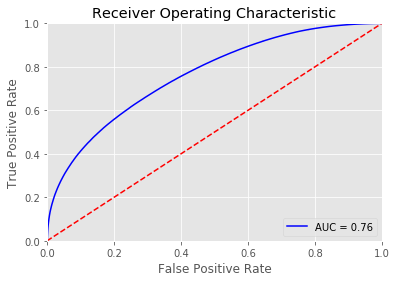

In [29]:
#%%pycodestyle
from sklearn.metrics import roc_curve, auc

probs = pip.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()